# PyTASER Examples


The examples given below use electronic structure information from the Materials Project database. They require an API key that you can get from https://materialsproject.org/open



As the database is built from density functional theory calculations using a semi-local exchange-correlation functional, the band gaps are underestimated, so we apply a scissors operator to recover the experimental bandgap in each case. This is necessary to directly compared predicted and modelled spectra.

## Setup

In [1]:
import sys
sys.path.append('/Users/youngwonwoo/Dropbox/program/PyTASER-main/PyTASER/pytaser/')
from pytaser import generator, plotter
%pylab inline

key = 'kZ8rIdQEyOpsf2JX'  # insert your own Materias Project key

/opt/anaconda3/lib/python3.8/site-packages/pymatgen/analysis/phase_diagram.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Populating the interactive namespace from numpy and matplotlib


## GaAs

/opt/anaconda3/lib/python3.8/site-packages/pymatgen/ext/matproj.py:182: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


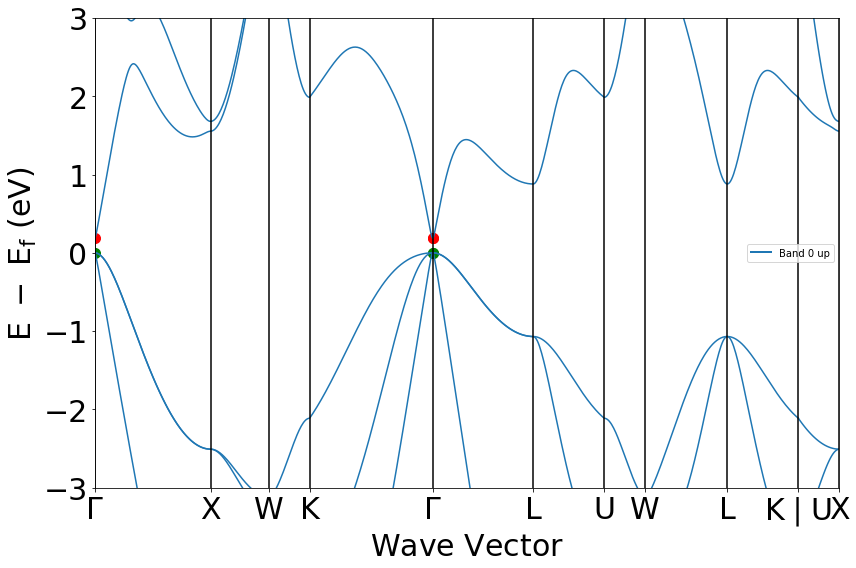

In [2]:
#Band structure read from pymatgen 
from pymatgen.ext.matproj import MPRester
from pymatgen.ext.matproj import TaskType
from pymatgen.electronic_structure.plotter import BSPlotter
api = MPRester(key)
bs = api.get_bandstructure_by_material_id("mp-2534")

from pymatgen.electronic_structure.plotter import BSPlotter
plt = BSPlotter(bs).get_plot(vbm_cbm_marker=True,ylim=[-3,+3])

/opt/anaconda3/lib/python3.8/site-packages/pymatgen/electronic_structure/dos.py:1371: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp((E - fermi) / (_cd("Boltzmann constant in eV/K") * T)))
/opt/anaconda3/lib/python3.8/site-packages/pytaser/plotter.py:8: RuntimeWarning: divide by zero encountered in true_divide
  wavelength = ((scpc.h * scpc.c) / (ev * scpc.electron_volt)) * 10e8


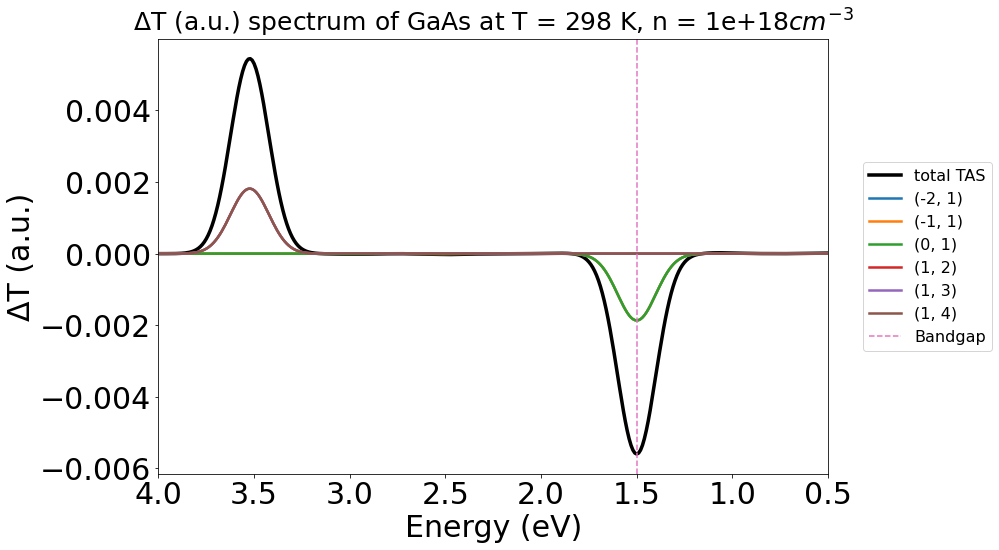

In [3]:
# Setting values
temp = 298 # temperature in Kelvin
conc = 1e18 # carrier concentration per cm3 
bandgap = 1.5 # eV, standard value at T = 300 K
key ="kZ8rIdQEyOpsf2JX"

# Run pyTASER
data = generator.TASGenerator.from_mpid("mp-2534", bandgap, api_key=key)
process = data.generate_tas(temp, conc)
plot = plotter.TASPlotter(process, bandgap, material_name="GaAs", temp=temp, conc=conc)

# Output energy plot 
energyplot = plot.get_plot(
    xaxis="energy", transition_cutoff=0.50, xmin=0.5, xmax=4, yaxis="tas")
# Reverse axis for better comparison to experiment
# You can change xaxis to "wavelength" 
energyplot.gca().invert_xaxis()

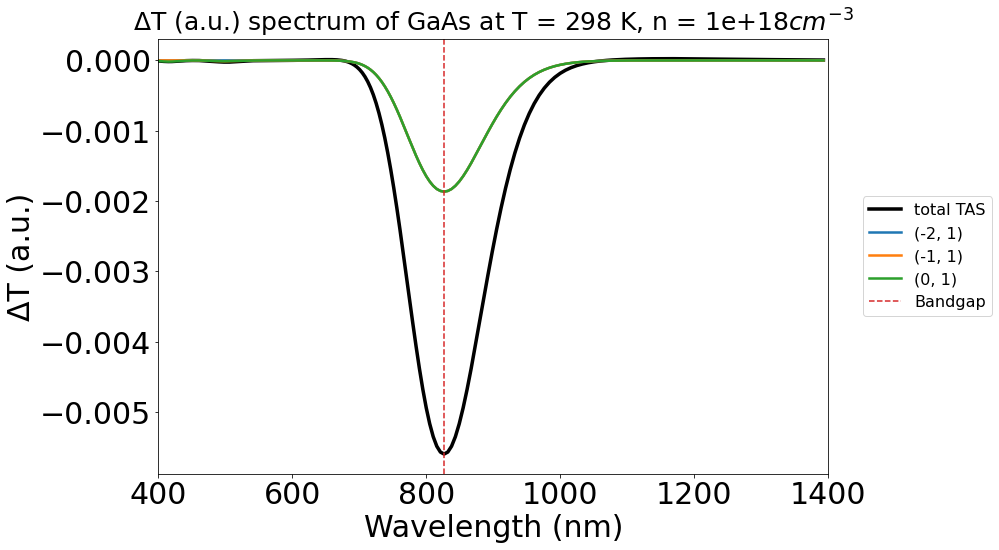

In [4]:
# Output wavelength plot
wavelengthplot = plot.get_plot(xaxis="wavelength",transition_cutoff=0.03,xmin=400,xmax=1400,yaxis="tas")

## PyTASER workflow with DFT

## rutile-TiO2

In [2]:
## Load DFT bandstructure and dos to prepare PyTASER run

# Read vasprun.xml,get band information
from pymatgen.io.vasp.outputs import BSVasprun, Vasprun
import os
import glob
from pymatgen.electronic_structure.bandstructure import get_reconstructed_band_structure

folders_bs = sorted(glob.glob("./TiO2/band/split-0*/"))
vaspruns_bs = []
for fol in folders_bs:
    vr_file = os.path.join(fol, "vasprun.xml")
    vaspruns_bs.append(vr_file)

# Get bandstructure and band gap
bandstructures = []
for vr_file in vaspruns_bs:
    vr = BSVasprun(vr_file, parse_projected_eigen=True)
    bs = vr.get_band_structure(line_mode=False)
    bandstructures.append(bs)
bandstructure = get_reconstructed_band_structure(bandstructures)

# Uniform k-point mesh band structure to get kpoint weight
kweights=[]
for fol in folders_bs:
    vr_file = os.path.join(fol, "vasprun.xml")
    vr = Vasprun(vr_file, parse_projected_eigen=False)
    kweight = vr.actual_kpoints_weights
    kweights.extend(kweight)
    
# Read vasprun.xml,get dos information
vasprun_dos = Vasprun("./TiO2/dostest/121218/vasprun.xml")
dos = vasprun_dos.complete_dos

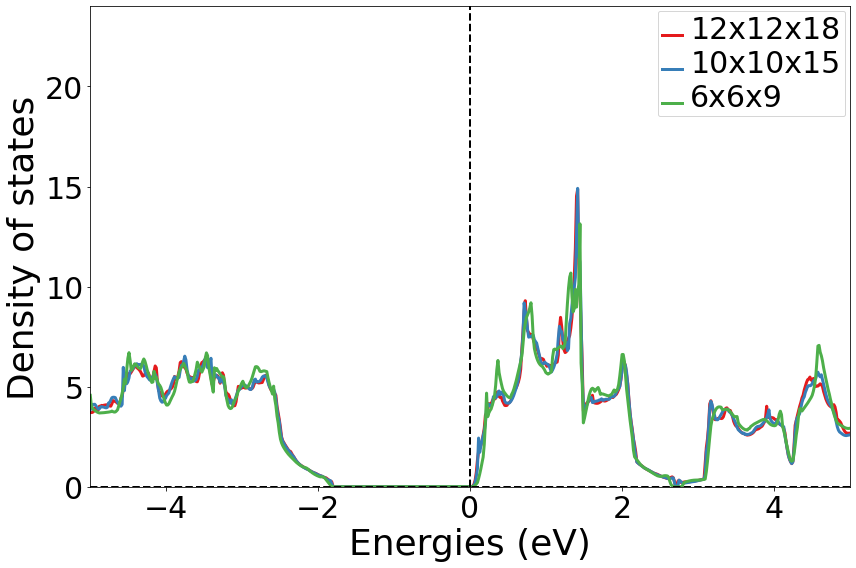

In [12]:
# DOS converge check, here I tested 6x6x9,10x10x15,12x12x18
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.io.vasp import Vasprun
from pymatgen.electronic_structure.dos import FermiDos

vasprun_dos = Vasprun("./TiO2/dostest/669/vasprun.xml")
dos1 = vasprun_dos.complete_dos
vasprun_dos = Vasprun("./TiO2/dostest/101015/vasprun.xml")
dos2 = vasprun_dos.complete_dos
vasprun_dos = Vasprun("./TiO2/dostest/121218/vasprun.xml")
dos3 = vasprun_dos.complete_dos


plotter_ = DosPlotter(zero_at_efermi= True, stack= False)
plotter_.add_dos_dict({"6x6x9":dos1,"10x10x15": dos2, "12x12x18": dos3})
plotter_.show(xlim=[-5, 5], ylim=[0, 24])

In [3]:
# Use scissor function to match bandstructure and dos with given bandgap 
# This process will change bandstructure -> new_bandstructure)
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine

new_band_gap=3.4  #value from hybrid calculation 
new_bandstructure = BandStructureSymmLine.apply_scissor(bandstructure,new_band_gap)

In [8]:
# This process will change dos -> new_dos
from pymatgen.electronic_structure.dos import FermiDos

dos.efermi=new_bandstructure.efermi
new_dos = FermiDos(dos, bandgap=new_band_gap)

In [10]:
# Setting values
temp = 298 # temperature in Kelvin
conc = 1e18 # carrier concentration per cm3 

# Run pyTASER
data_dft = generator.TASGenerator(new_bandstructure, kweights, new_dos)
process_dft= data_dft.generate_tas(energy_min=0.0, energy_max=5, temp=temp, conc=conc)
plot_dft = plotter.TASPlotter(process_dft, new_band_gap, material_name="TiO2", temp=temp, conc=conc)

/opt/anaconda3/lib/python3.8/site-packages/pymatgen/electronic_structure/dos.py:1371: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp((E - fermi) / (_cd("Boltzmann constant in eV/K") * T)))
/opt/anaconda3/lib/python3.8/site-packages/pytaser/plotter.py:8: RuntimeWarning: divide by zero encountered in true_divide
  wavelength = ((scpc.h * scpc.c) / (ev * scpc.electron_volt)) * 10e8


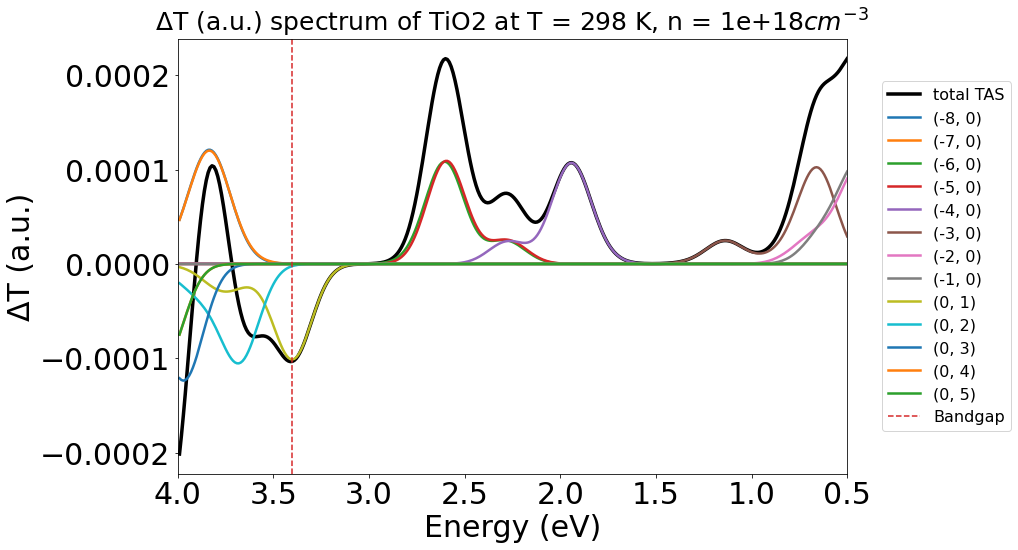

In [17]:
# Output energy plot 
energyplot_dft = plot_dft.get_plot(xaxis="energy", transition_cutoff=0.03, xmin=0.5, xmax=4, yaxis="tas")
# Reverse axis for better comparison to experiment
# You can change xaxis to "wavelength" 
energyplot_dft.gca().invert_xaxis()

## Comparison between database and DFT calculation data by heatmap

In [12]:
#Read TiO2 data and generate TAS from materials project
process_mp = generator.TASGenerator.from_mpid("mp-2657", new_band_gap, api_key=key).generate_tas(temp,conc)
plot_mp = plotter.TASPlotter(process_mp, new_band_gap, material_name="TiO2", temp=temp, conc=conc)

/opt/anaconda3/lib/python3.8/site-packages/pymatgen/ext/matproj.py:182: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


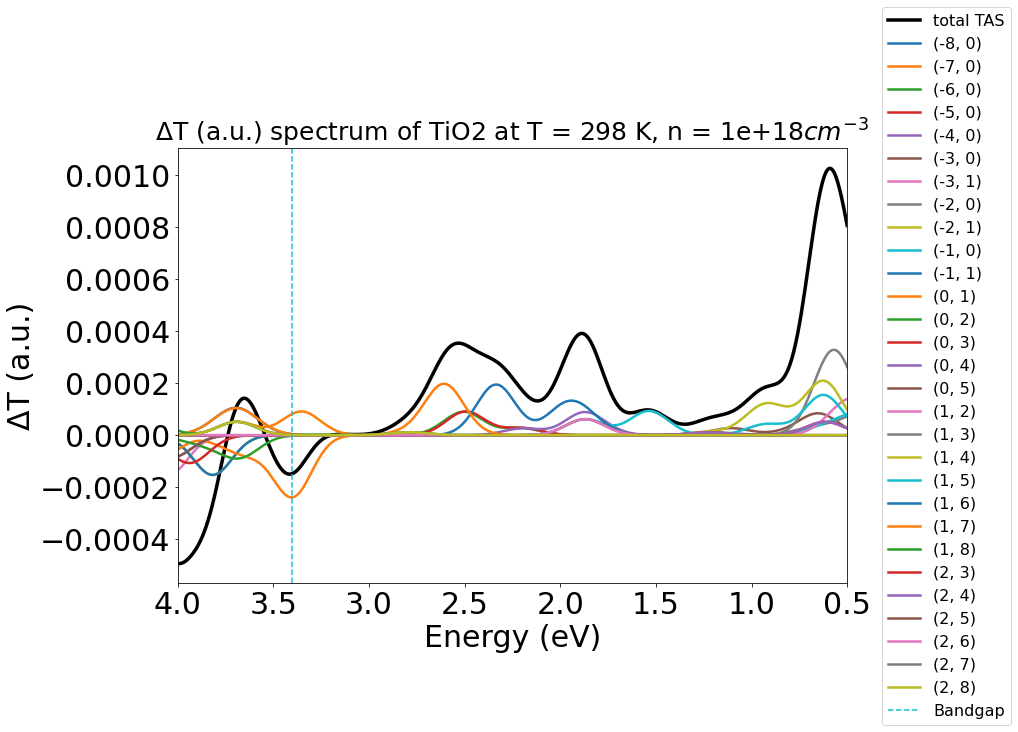

In [18]:
#TiO2 TAS spectra from MP
plot_mp = plotter.TASPlotter(process_mp, new_band_gap, material_name="TiO2", temp=temp, conc=conc)
energyplot_mp = plot_mp.get_plot(xaxis="energy", transition_cutoff=0.03, xmin=0.5, xmax=4, yaxis="tas")
energyplot_mp.gca().invert_xaxis()

In [19]:
tas_container=[process_mp,process_dft]
tas_name=["Database","DFT"]

In [20]:
import pandas as pd
df = pd.DataFrame(tas_name, columns = ['material ID'])
df['tas'] = tas_container

#Code to get a dataframe of important values
tas = pd.DataFrame(columns=['Material ID','Total delta T'])
energy_mesh = []

#Get Material ID and total tas from tas_container class and add to the tas dataframe
for i in range(len(tas_name)):
    current_tas = df.iloc[i]['tas']
    data = {'Material ID':tas_name[i],'Total delta T': current_tas.total_tas}
    tas = tas.append(data, ignore_index = True)
    energy_mesh.append(current_tas.energy_mesh_ev)

#Split list into columns
split = pd.DataFrame(tas['Total delta T'].tolist())   
tas = pd.concat([tas, split], axis=1).drop('Total delta T', axis=1).set_index('Material ID')

# Create tas csv file
tas.to_csv('tas.csv')
data = pd.read_csv('tas.csv')
data.head()

,Material ID,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,Database,3.660503e-06,4.795239e-06,6.220610e-06,7.991370e-06,1.016693e-05,1.281023e-05,1.598608e-05,1.975920e-05,2.419172e-05,...,-0.000082,-0.000083,-0.000083,-0.000082,-0.000081,-0.000078,-0.000075,-0.000072,-0.000068,-0.000063
1,DFT,1.772972e-08,2.717902e-08,4.125001e-08,6.198302e-08,9.221041e-08,1.358144e-07,1.980479e-07,2.859260e-07,4.086920e-07,...,0.000073,0.000077,0.000082,0.000086,0.000091,0.000095,0.000099,0.000103,0.000106,0.000108


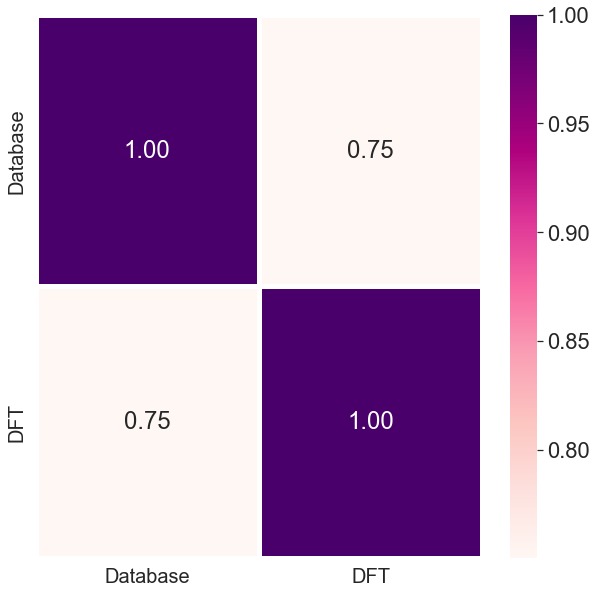

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
#Gernerate heatmap
tas = pd.read_csv('tas.csv', index_col=0)
matrix = tas.T.corr()
matrix = matrix[abs(matrix)>=0.01]

sns.heatmap(matrix, annot=True, fmt='.2f', linewidths=5, cmap='RdPu')
sns.set(rc = {'figure.figsize':(10,10)},font_scale = 2)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tight_layout
plt.show()